In [2]:
import os, zipfile
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists, splitext

import sys
import numpy as np
import tensorflow as tf
import sys
import pandas as pd


from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib inline

import seaborn as sns

import cardio
import cardio.dataset as ds
from cardio import EcgBatch, EcgDataset


from scipy.stats import beta

from cardio.dataset import B, V, F
from cardio.models.metrics import f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Training network from scratch on OSU data

In [4]:
SIGNALS_PATH = "/home/kate/Research/Raw Data/All WFDB/" # train-test data
SIGNALS_MASK = SIGNALS_PATH + "*.hea"
LABELS_PATH = SIGNALS_PATH + "REFERENCE.csv"

In [5]:
eds = EcgDataset(path=SIGNALS_MASK, no_ext=True, sort=True)
eds.cv_split(0.8)

In [6]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "input_shape": F(lambda batch: batch.signal[0].shape[1:]),
    "class_names": F(lambda batch: batch.label_binarizer.classes_),
    "loss": None,
}

In [7]:
N_EPOCH = 1000 
BATCH_SIZE = 256

In [14]:
template_train_ppl = (
    ds.Pipeline()
      .init_model("dynamic", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("loss_history", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .drop_labels(["N"])
      .band_pass_signals(low=4, high=25)
      .flip_signals()
      .random_resample_signals("normal", loc=300, scale=10)
      .random_split_signals(2048, {"D": 8, "ND": 2})
      .binarize_labels()
      .train_model("dirichlet", make_data=concatenate_ecg_batch,
                   fetches="loss", save_to=V("loss_history"), mode="a")
      .call(lambda _, v: print(v[-1]), v=V('loss_history'))
      .run(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=N_EPOCH, lazy=True)
)

train_ppl = (eds.train >> template_train_ppl).run()

-0.52608335
-0.62128776
-0.7285265
-0.34415114


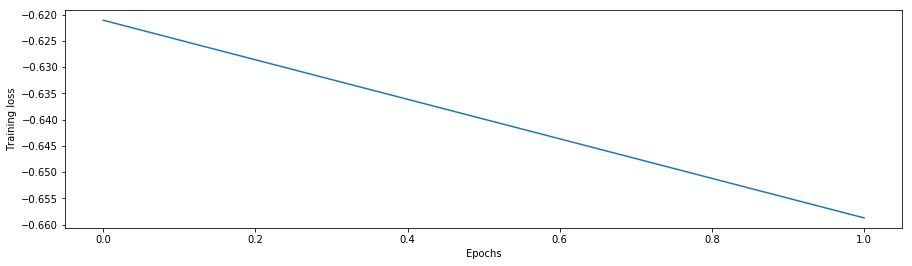

In [12]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()